In [288]:
import numpy as np
import sys
from scipy.special import gamma, digamma, polygamma
import random
from scipy.stats import dirichlet
from matplotlib import pyplot as plt
import time

import torch

### I) Code de l'algo de Minka pour l'estimation d'une Dirichlet:

In [2]:
#Fonction permettant d'initialiser x
def initialisation(y):
    M = (y >= -2.22);
    x = M *(np.exp(y) + 0.5) + (1-M) * -1/(y+digamma(1))
    
    return x

In [3]:
#Fonction pour les iéterations de point-fixe (Newton)
def newton(y):
    # initialisation de x
    x = initialisation(y)
    
    for i in range(6):
        x = x - (digamma(x) - y)/polygamma(1,y)
        i +=1
    
    return x

In [4]:
#s la matrice des sources en taille Nxp
#p le nombre d'endmembers

def alpha_hat(s):
    #0) Vérification de la taille:
    if np.shape(s)[0] < np.shape(s)[1]:
        return(print("Error: verify the shape  Nxp of the entry."))

    #1) Calcul des log hat(p_k)
    p = np.shape(s)[1]
    p_mean = [0]*p #Vecteur de stockage des p_i_mean
    
    for i in range(p):
        p_mean[i] = np.mean(np.log(np.transpose(s)[i]));
    
    #2) Estimation du maximum de vraisemblance par méthode de Newton
    alpha = [1]*p #Initialisation des alpha
    y_ = [0]*p #Vecteur de stockage des y_i
    
    for i in range(2000): #Le nombre d'itérations (1000 est un choix sûr).
        for k in range(p):
            y_[k] = digamma(sum(alpha)) + p_mean[k]
            alpha[k] = newton(y_[k])
    
    return alpha

In [10]:
#Utiliser la fct alpha_hat pour inférer les paramètres de la dirichlet
s = np.random.dirichlet((101,5,9,2), 10000)
print(s, f"Il y à {np.shape(s)[0]} vecteurs de taille {np.shape(s)[1]}")

[[0.83693244 0.02300912 0.11778334 0.02227509]
 [0.89685055 0.02297924 0.06663154 0.01353868]
 [0.88199704 0.03427953 0.0760265  0.00769693]
 ...
 [0.8272432  0.0315792  0.10322439 0.03795321]
 [0.88008609 0.05604925 0.06159753 0.00226713]
 [0.8351767  0.04688822 0.07478096 0.04315413]] Il y à 10000 vecteurs de taille 4


In [11]:
#Vérification
print(alpha_hat(s))

[102.70077672200637, 5.097229431683883, 9.129457273954513, 2.0190213997642306]


#### Remarque: L'algo n'est pas sensible aux initialisations. Il est aussi plutôt rapide. Afin de s'assurer de la convergence, mieux vaut prendre un nombre d'itérations assez élevé. 

### a) Test sur les jeux de données ( 4 EM, après validation de la contrainte de positivité stricte))


In [87]:
#Création d'une fonction qui convertit les fichiers mat en numpy

import scipy.io
import numpy as np

def conversion_array(filename):
    mat = scipy.io.loadmat(filename)
    data = list(mat.items())
    an_array = np.array(data,dtype=object)
    
    return an_array[3,1]

In [88]:
#Chargement des données hyperspectrales
Modified_s = conversion_array('Modified_s')
np.shape(np.transpose(Modified_s))

(10000, 4)

In [90]:
#Vérification
print(alpha_hat(np.transpose(Modified_s)))

/tmp/ipykernel_310419/1283943213.py:4: RuntimeWarning: overflow encountered in exp
  x = M *(np.exp(y) + 0.5) + (1-M) * -1/(y+digamma(1))
/tmp/ipykernel_310419/3699610980.py:7: RuntimeWarning: invalid value encountered in double_scalars
  x = x - (digamma(x) - y)/polygamma(1,y)


[nan, nan, nan, nan]


#### Ne fonctionne pas avec une seule Dirichlet. A tester avec 2 EM uniquement (donc juste une partie de l'image) pour voir si ça marche.

### b) Test sur l'image cropped avec 2 EM uniquement:

In [ ]:
S2 = conversion_array('S2')
S2_1 = S2[0][0:3023]
S2_2 = S2[2][0:3023]
S_ = np.transpose([S2_1, S2_2])
np.shape(S_)

In [ ]:
liste = []

S_ = list(S_)
for i in range(3023):
    if S_[i][0]!=0 and S_[i][1]!=0:
        liste.append(S_[i])
        
print(np.shape(liste))

In [20]:
liste

[array([0.5599831, 0.4400169]),
 array([0.5599831, 0.4400169]),
 array([0.70533056, 0.29466944]),
 array([0.61718815, 0.38281185]),
 array([0.70623016, 0.29376984]),
 array([0.78327174, 0.21672826]),
 array([0.77484116, 0.21422421]),
 array([0.6611585 , 0.33821227]),
 array([0.58867672, 0.41132328]),
 array([0.66672705, 0.33327295]),
 array([0.93595997, 0.06404003]),
 array([0.98180335, 0.01819665]),
 array([0.89538343, 0.10461657]),
 array([0.76387079, 0.23612921]),
 array([0.59161734, 0.40838266]),
 array([0.4067107, 0.5932893]),
 array([0.23147965, 0.76852035]),
 array([0.44881191, 0.55118809]),
 array([0.7100853, 0.2899147]),
 array([0.88302811, 0.11697189]),
 array([0.9963333, 0.0036667]),
 array([0.99162706, 0.00837294]),
 array([0.97504797, 0.02495203]),
 array([0.78809149, 0.21190851]),
 array([0.72720969, 0.27279031]),
 array([0.62838189, 0.3678039 ]),
 array([0.71529901, 0.28470099]),
 array([0.89374102, 0.10625898]),
 array([0.95828611, 0.04171389]),
 array([0.93563095, 0.06

In [21]:
print(alpha_hat(liste))

[0.6959100249631485, 0.6341020192369585]


#### Remarque 1: Pour que ça marche, on a du enlever tous les pixels purs. [La parcimonie n'est pas bien prise en compte]
#### Remarque 2: Il semblerait que l'estimation ne soit pas vraiment fiable; mieux vaut passer par un EM !

### II) EM pour les dirichlets:

In [272]:
def EM_dirichlet(s,kmax,niter):
    
    #s: abundance matrix (pxN)
    #kmax: Max number of modes
    #niter: Nb. of iterations

    N = np.shape(s)[0] #nombre d'observations dans le dataset
    p = np.shape(s)[1] #nombre d'endmembers

    beta = np.ones((N,kmax)) #La proba pour une obs (i) d'avoir été générée par un modèle q=1,...,kmax 
    eps = np.ones(kmax)*(1/kmax) #Initialisation des probas de modèles
    theta = np.zeros((kmax,p)) #Initialisation des paramètres des modèles
    
    #Labels = np.zeros((N,1)) #Matrice où on stock les labels prédits (le max des beta)
    
    for i in range(kmax):
        for j in range(p):
            theta[i][j] = random.randint(1,10)   #Attention à ne pas avoir de paramètres theta à zéro !  (>>0)
    
    L = []
    somme_theta = np.zeros(kmax)
    
    for t in range(niter):
    
        #Mise à jour de l'ensemble des beta_q d'une traite
        for i in range(N):
            somme_densities = 0
            for l in range(kmax):
                beta[i][l] = eps[l]*dirichlet.pdf(s[i],theta[l])
            beta[i] = beta[i]/np.sum(beta[i])
            
        #Mise à jour de l'ensemble des epsilon d'une traite      
        for q in range(kmax):
            eps[q] = (1/N)*sum(beta[:,q])
    
        for q in range(kmax): #avant d'upload les theta, sauvegarder la somme qui sera utilisée dans la last step
            somme_theta[q] = np.sum(theta[q]) #On sauvegarde la somme avant mise à jour !
    
     
    
        for q in range(kmax):
            for j in range(p):
            
                prod_beta = 0 #Il en faut un nouveau à chaque j
            
                for i in range(N):
                    prod_beta += beta[i,q]*np.log(s[i][j])

                theta[q][j] = newton( digamma(somme_theta[q]) + (prod_beta/np.sum(beta[:,q])) )
    
        #Affichage de la log vraisemblance
        L_t = 0
        for i in range(N):
            L_q = 0
            for q in range(kmax):
                L_q += eps[q]*dirichlet.pdf(s[i],theta[q])
            L_q = np.log(L_q)
            L_t += L_q
    
        L.append(L_t) #Enregistrement de la log vraisemblance à chaque itération
    
    
    #Mise à jour des labels:
    Labels = np.argmax(beta, axis=1) #On prend l'argument maximal parmi les probabilités relatives
    
    
    return Labels, theta, eps, L

In [273]:
#Echantillonnage de s:
s1 = np.random.dirichlet((10, 5, 3), 1000)
s2 = np.random.dirichlet((6, 7, 9), 3000)
s3 = np.random.dirichlet((2, 2, 9), 2000)
s = np.concatenate((s1,s2,s3))
np.shape(s)

(6000, 3)

In [220]:
B_5 = []
B_4 = []
B_3 = []
B_2 = []

In [274]:
t = time.time()
beta_5, theta_5, eps_5, L5 = EM_dirichlet(s,3,200)
elapsed = time.time() - t

In [275]:
theta_5

array([[2.13824537, 2.05678257, 9.59748605],
       [6.20643339, 7.33934818, 9.32330057],
       [9.67092594, 5.01125328, 3.10411604]])

In [283]:
unique, counts = np.unique(beta_5, return_counts=True)
print(np.asarray((unique, counts/6000)).T) 

[[0.         0.314     ]
 [1.         0.52066667]
 [2.         0.16533333]]


In [279]:
print(1000/6000, 3000/6000, 2000/6000)

0.16666666666666666 0.5 0.3333333333333333


In [222]:
print(elapsed)

181.33108472824097


In [284]:
theta_5, eps_5

(array([[2.13824537, 2.05678257, 9.59748605],
        [6.20643339, 7.33934818, 9.32330057],
        [9.67092594, 5.01125328, 3.10411604]]),
 array([0.33157989, 0.49232635, 0.17609376]))

In [224]:
t = time.time()
theta_4, eps_4, L4 = EM_dirichlet(s,4,100)
elapsed = time.time() - t
print(elapsed)

146.69048357009888


In [225]:
theta_4, eps_4

(array([[ 1.96554431,  2.19373833,  7.27095794],
        [ 2.24130959,  2.09197641, 10.66775753],
        [ 5.99238569,  6.97446051,  9.04301098],
        [ 8.66591047,  4.21220706,  2.82860665]]),
 array([0.08632731, 0.24155521, 0.48359823, 0.18851926]))

In [226]:
t = time.time()
theta_3, eps_3, L3 = EM_dirichlet(s,3,100)
elapsed = time.time() - t
print(elapsed)

109.71951055526733


In [227]:
theta_3, eps_3

(array([[2.10153971, 2.05655323, 9.14941498],
        [6.41012941, 7.54722958, 9.65073687],
        [8.72466767, 4.25685127, 2.88419718]]),
 array([0.33750051, 0.46955773, 0.19294176]))

In [228]:
t = time.time()
theta_2, eps_2, L2 = EM_dirichlet(s,2,100)
elapsed = time.time() - t
print(elapsed)

74.41563129425049


In [229]:
theta_2, eps_2

(array([[3.56378138, 3.14503466, 3.37706424],
        [2.08838214, 2.1686459 , 8.82467986]]),
 array([0.65167001, 0.34832999]))

## Computing the AIC criteria for model selection

In [103]:
for i in range(100):
    B_5.append(-2*L5[i]+2*5)
    B_4.append(-2*L4[i]+2*4)
    B_3.append(-2*L3[i]+2*3)
    B_2.append(-2*L2[i]+2*2)

In [104]:
print(B_5[99],B_4[99],B_3[99],B_2[99])

-21839.452317478863 -21867.14985067708 -21861.7811359475 -20165.047726813966


#### Le modèle sélectionné est celui dont le score AIC est le plus bas:
Ici c'est kmax = 3; ce qui correspond bien au nombre de modèles de mélanges.

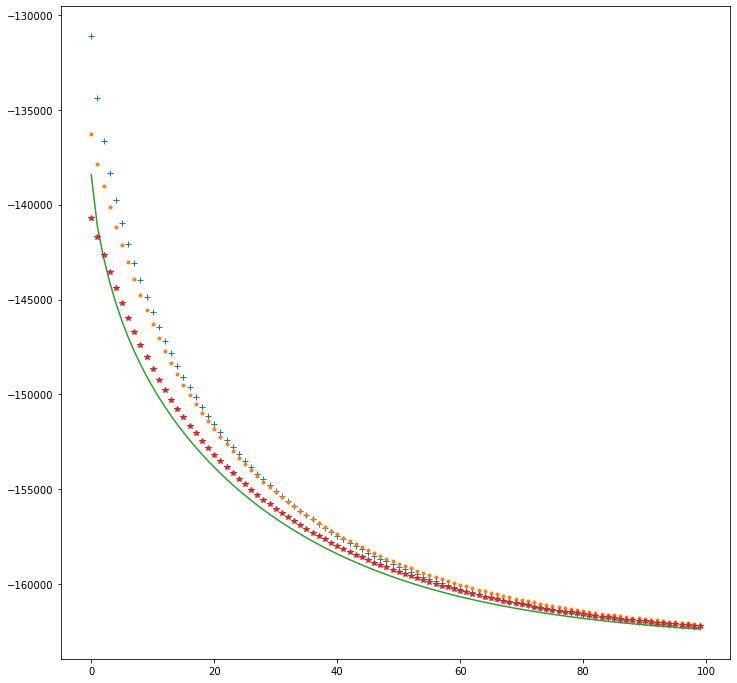

In [55]:
#Affichage de l'évolution de la vraisemblance en fct des itérations
figure(figsize=(12, 12))
plt.plot(B_5,'+')
plt.plot(B_4,'.')
plt.plot(B_3,'-')
plt.plot(B_2,'*')
#plt.xlim([80,100])
plt.show()

## Calcul du critère MDL pour la séléction de modèle:

In [179]:
def dirichlet_mixtures_density(s,theta_list,proba_list):
    
    #Description: This function enables to compute the probability density for some observation s
    #following a Dirichlet Mixture model of parameters proba_list and theta_list.
    
    #theta_list: list of parameters for each mode of the mixture
    #proba_list: the probability associated to each mode 
    #s: quantiles (observations)
    
    log_likelihood = 0
    
    for i in range(len(proba_list)):
        log_likelihood += proba_list[i]*dirichlet.logpdf(s, theta_list[i])
        
    return log_likelihood

In [180]:
def global_dirichlet_mixtures_density(S,theta_list,proba_list):
    
    #Description: This function computes the global density of the dirichlet mixture model, i.e over all
    #the observations S. We make the hypothesis that the obs S[i] are iid, so the global likelihood corresponds
    #to the product of the individual densities over the observations.
    
    global_loglikelihood = 0
    
    for i in range(len(S)):
        global_loglikelihood += dirichlet_mixtures_density(S[i],theta_list,proba_list)
    
    return global_loglikelihood

In [714]:
def MDL(loglikelihood, k, p, N, proba_list):
    
    #Description: This function computes the Minimum Description Length (MDL) of some model s.t:
    
    #loglikelihood: is the aggregated log-likelihood of this model over a complete dataset.
    #proba_list: are the probabilities associated to the dirichlet densities of the mixture model
    #k: the number of modes of the model
    #p: the number of parameters of the Dirichlet
    #N: the number of observation (size of the dataset S)
    #proba_list: are the probabilities associated to the dirichlet densities of the mixture model
    
    return -loglikelihood + k*(p+1)/2 + k*np.log(N/12)/2 + 0.5*np.sum(np.log(N*proba_list/12))

### Test sur un exemple simple:

In [213]:
#Echantillonnage de s:
s1 = np.random.dirichlet((10, 5, 3), 1000)
s2 = np.random.dirichlet((6, 7, 9), 3000)
s3 = np.random.dirichlet((2, 2, 9), 2000)
s = np.concatenate((s1,s2,s3))
np.shape(s)

(6000, 3)

In [206]:
#Si on regarde la prédiction faite par l'algorithme EM, la prédiction avec 3 clusters est très bonne.
theta_3, eps_3 #Assez proche

(array([[ 6.08515501,  6.9253172 ,  8.91613779],
        [ 2.13155987,  2.11639444,  9.62613095],
        [11.02047576,  5.47935977,  3.1794027 ]]),
 array([0.51042606, 0.32756318, 0.16201076]))

In [207]:
theta_4, eps_4 #Le modèle avec 4 clusters se rapproche du résultat optimal, avec une proba assez faible
#pour le cluster supplémentaire.
#Cependant, on ne peut pas se limiter à ça, car il peut y avoir au sein d'un jeu de données un cluster sous-
#représenté, et donc dans ce cas l'enlever n'aurait pas de sens.

(array([[ 6.13645397,  6.93166053,  8.9871489 ],
        [ 2.13893481,  2.12189229,  9.77269821],
        [ 4.14674633,  4.80095407,  6.02126563],
        [11.41023797,  5.635037  ,  3.22875318]]),
 array([0.47238983, 0.32224247, 0.04691743, 0.15845027]))

In [ ]:
loglikelihood_5 = global_dirichlet_mixtures_density(s,theta_5,eps_5)
loglikelihood_4 = global_dirichlet_mixtures_density(s,theta_4,eps_4)
loglikelihood_3 = global_dirichlet_mixtures_density(s,theta_3,eps_3)
loglikelihood_2 = global_dirichlet_mixtures_density(s,theta_2,eps_2)

In [215]:
MDL(loglikelihood_5, k=5, p=3, N=len(s), proba_list=eps_5)

9914.061604301043

In [216]:
MDL(loglikelihood_4, k=4, p=3, N=len(s), proba_list=eps_4)

8517.755113884792

In [217]:
MDL(loglikelihood_3, k=3, p=3, N=len(s), proba_list=eps_3)

8400.803621655803

In [218]:
MDL(loglikelihood_2, k=2, p=3, N=len(s), proba_list=eps_2)

-761.9742522411378

### [Version Préliminaire: EM avec mixtures de gaussiennes pour l'image Jasper]

In [769]:
#Chargement des données
X_jasper = scipy.io.loadmat('Y.mat')
X_jasper = list(X_jasper.items())
X_jasper = np.array(X_jasper,dtype=object)
X_jasper = X_jasper[7,1]
X_jasper = torch.tensor(X_jasper.astype(float))
X_jasper = torch.reshape(X_jasper,(1,198,10000))
# np.shape(X_jasper)

A_jasper = scipy.io.loadmat('M.mat')
A_jasper = list(A_jasper.items())
A_jasper = np.array(A_jasper,dtype=object)
A_jasper = A_jasper[4,1]
A_jasper = torch.tensor(A_jasper.astype(float))
A_jasper = torch.reshape(A_jasper,(1,198,4))
#np.shape(A_jasper)

S_jasper = scipy.io.loadmat('A.mat')
S_jasper = list(S_jasper.items())
S_jasper = np.array(S_jasper,dtype=object)
S_jasper = S_jasper[3,1]
S_jasper = torch.tensor(S_jasper.astype(float))
S_jasper = torch.reshape(S_jasper,(1,4,10000))
#np.shape(S_jasper)

In [770]:
#Mise à la bonne taille et affichage
img = S_jasper[0].T

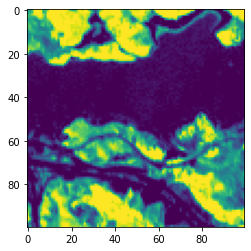

In [771]:
i=0
plt.imshow(np.reshape(img, [100,100,4])[:,:,i])

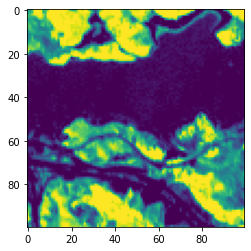

In [772]:
img2 = (img+0.001)/1.004
plt.imshow(np.reshape(img, [100,100,4])[:,:,i])

In [ ]:
from sklearn.mixture import GaussianMixture as GMM

#Clustering par mixtures de gaussiennes
gmm_model = GMM(n_components=12, covariance_type='diag', init_params='kmeans').fit(img2)

gmm_labels = gmm_model.predict(img2)

#Représentation en image de l'estimation
original_shape = [100,100,4]
segmented = gmm_labels.reshape(original_shape[0], original_shape[1])

plt.figure(figsize=(5,5))
plt.imshow(segmented, cmap='Paired');
plt.colorbar()

In [ ]:
#Accès aux labels prédits
gmm_labels

In [ ]:
#Access to the initialization parameters
gmm_model.get_params()

In [ ]:
#Access to the covariance matrices
print(f'{gmm_model.covariances_}, of size {np.shape(gmm_model.covariances_)}')

In [ ]:
#Access to the mean vectors
print(f" The mean vectors {gmm_model.means_}, there are {np.shape(gmm_model.means_)[0]} vectors of size {np.shape(gmm_model.means_)[1]}")

In [ ]:
#Access to the probability related to each cluster
gmm_model.weights_

In [ ]:
#Calcul des probas associées à chaque cluster
unique, counts = np.unique(gmm_labels, return_counts=True)
print(np.asarray((unique, counts/10000)).T)

In [ ]:
#Génération de samples à partir des paramètres estimés et fit sur les données initiales pour comparer
generated_samples, associated_labels = gmm_model.sample(10000)

#Samples générés
generated_samples

In [ ]:
#Labels associés aux samples générés
associated_labels

In [ ]:
i=0

#Fitted data (Blue)
plt.hist(generated_samples[:,i], bins=120) #np.linspace(0,1,num=12)); #120

#Original data (Orange)
plt.hist(img.detach().numpy()[:,i], bins=80) #np.linspace(0,1,num=12)); #80

plt.xlim([-0.2,1.2])
plt.show()

In [ ]:
#Séléction du meilleur modèle en fonction du critère BIC (se référer à la docu sklearn)
n_components = np.arange(1,30)
gmm_models = [GMM(n, covariance_type='spherical').fit(img) for n in n_components]

plt.plot(n_components, [m.bic(img) for m in gmm_models], label='AIC')
plt.xlabel('n_components')

## EM Dirichlet sur l'image Jasper [Version finale]

[Préliminaire: D'abord, il a fallu utiliser un EM pour mixtures de gaussiennes. Après avoir pu approximer les cartes d'abondance par les mixtures de gaussiennes, il y avait une sorte de preuve de concept. => Les détails sont dans la section avant.]
Pour le faire fonctionner, il a fallu ajouter à la carte d'abondance une constante 0.001 et renormaliser en divisant chaque ligne par 1.004. Pour la séléction de modèle, le MDL criteria a été utilisé.

### Test 22/11/22: EM Dirichlet sur les données Jasper

In [289]:
X_jasper = scipy.io.loadmat('Y.mat')
X_jasper = list(X_jasper.items())
X_jasper = np.array(X_jasper,dtype=object)
X_jasper = X_jasper[7,1]
X_jasper = torch.tensor(X_jasper.astype(float))
X_jasper = torch.reshape(X_jasper,(1,198,10000))
# np.shape(X_jasper)

A_jasper = scipy.io.loadmat('M.mat')
A_jasper = list(A_jasper.items())
A_jasper = np.array(A_jasper,dtype=object)
A_jasper = A_jasper[4,1]
A_jasper = torch.tensor(A_jasper.astype(float))
A_jasper = torch.reshape(A_jasper,(1,198,4))
#np.shape(A_jasper)

S_jasper = scipy.io.loadmat('A.mat')
S_jasper = list(S_jasper.items())
S_jasper = np.array(S_jasper,dtype=object)
S_jasper = S_jasper[3,1]
S_jasper = torch.tensor(S_jasper.astype(float))
S_jasper = torch.reshape(S_jasper,(1,4,10000))
#np.shape(S_jasper)

In [ ]:
#Tests pour savoir jusqu'à quelle erreur ajoutée aux 0 le EM fonctionne toujours

In [637]:
#Image originale
original_image = S_jasper[0].T
original_image = original_image.detach().numpy()

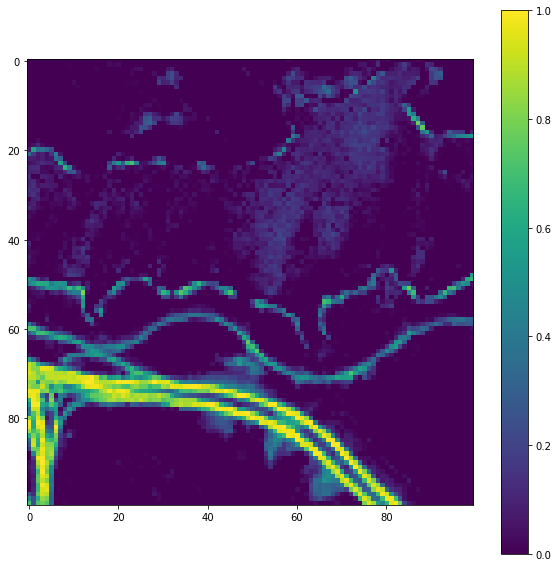

In [686]:
i = 3
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(original_image, [100,100,4])[:,:,i], vmin=0, vmax=1)#, cmap='Paired');
plt.colorbar()

In [653]:
#Image sans valeurs nulles
modified_image = (original_image +0.001)/1.004 #Suppression des 0
#np.sum(modified_image, axis=1) #!! Toujours vérifier la somme à 1 après modification

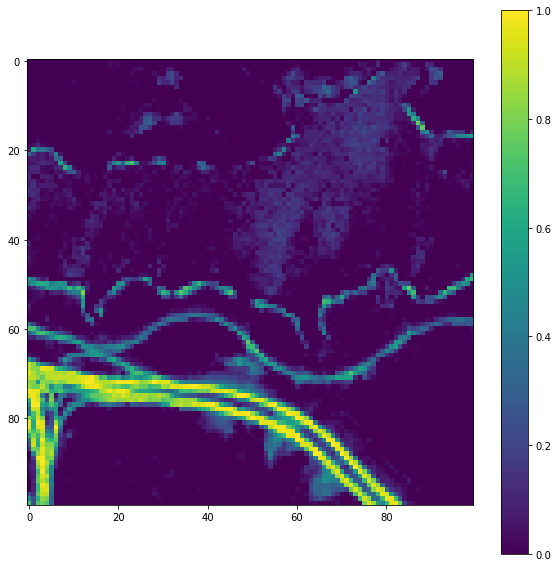

In [682]:
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(modified_image, [100,100,4])[:,:,i], vmin=0, vmax=1)#, cmap='Paired');
plt.colorbar()

In [665]:
#Lancement de l'algo sur l'image
t = time.time()
beta_modified, theta_modified, eps_modified, Lmodified = EM_dirichlet(modified_image,12,100)
elapsed = time.time() - t

In [667]:
Affichage du temps de calcul
print(f"It took {elapsed/60} minutes to run")

It took 12.080783287684122 minutes to run


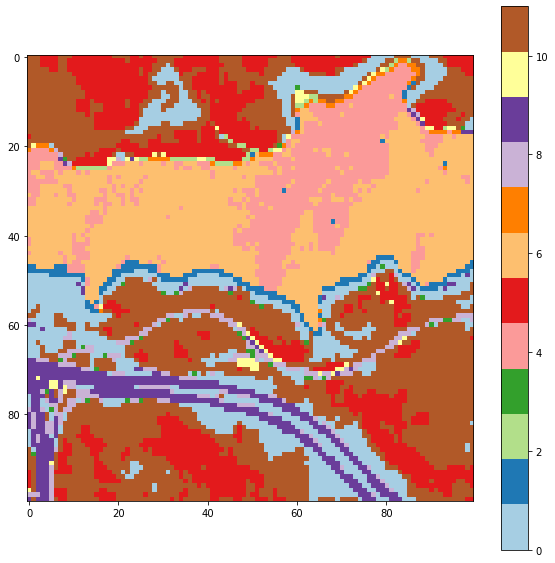

In [669]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_modified,[100,100]), cmap='Paired');
plt.colorbar()

##### Conclusion of this part:
Pour que le EM marche plutôt bien même en présence d'abondances nulles, on peut ajouter à tout la carte d'abondance 0.001 en veillant à diviser chaque ligne par 1.004, et ainsi ne dégrader que de très peu les scores initaux. A titre d'exemple: 0.9 devient 0.897 | 0.7 devient 0.698 ... etc et donc 0 devient 0.0009.

#### Test sur l'image de Dirichlet

In [337]:
#On définit l'image
img = S_jasper[0].T #Image initiale
img = (img+0.001)/1.004 #Suppression des 0
img = img.detach().numpy()

In [338]:
#Lancement de l'algo sur l'image
t = time.time()
beta_5, theta_5, eps_5, L5 = EM_dirichlet(img,12,100)
elapsed = time.time() - t

In [347]:
eps_5

array([2.02623651e-01, 1.87525449e-02, 1.58243938e-01, 1.91946923e-02,
       1.58450484e-04, 2.70974567e-01, 3.39627185e-14, 1.04080945e-01,
       1.05881648e-01, 3.48312554e-02, 2.70308147e-02, 5.82274938e-02])

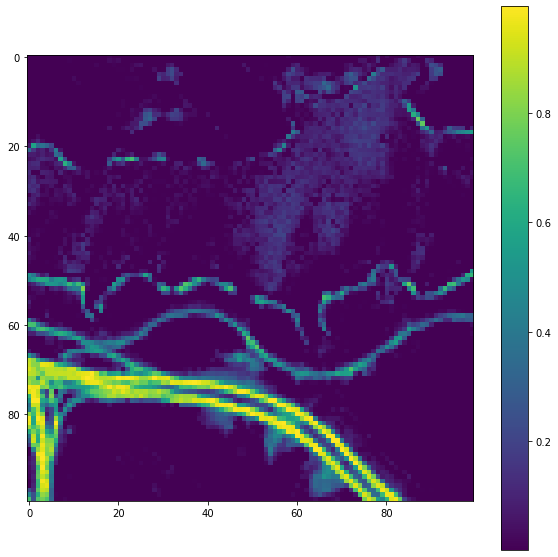

In [372]:
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(img, [100,100,4])[:,:,3])#, cmap='Paired');
plt.colorbar()

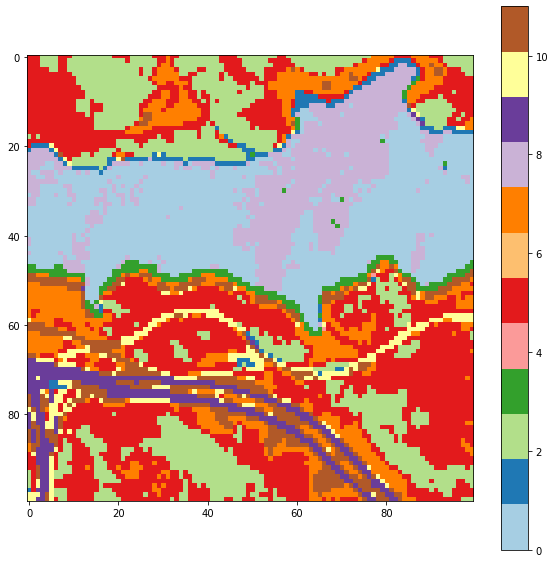

In [346]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_5,[100,100]), cmap='Paired');
plt.colorbar()

#### Superposition des histogrammes

In [723]:
#Superposition des histogrammes

#On transforme
proportion_5 = eps_5*10000
proportion_5 = [int(x) for x in proportion_5]
size_samples = sum(proportion_5)
proportion_5, print(np.shape(eps_5), size_samples) #La proba associé à chaque gaussienne du mélange

(12,) 9994


([1392, 168, 41, 37, 1033, 1488, 2051, 63, 243, 465, 69, 2944], None)

In [722]:
eps_5

array([2.02623651e-01, 1.87525449e-02, 1.58243938e-01, 1.91946923e-02,
       1.58450484e-04, 2.70974567e-01, 3.39627185e-14, 1.04080945e-01,
       1.05881648e-01, 3.48312554e-02, 2.70308147e-02, 5.82274938e-02])

In [720]:
theta_5, print(np.shape(theta_5)) #Les paramètres associés à chaque gaussienne

(12, 4)


(array([[ 0.32331342,  0.20397864,  2.85456489,  0.60984298],
        [ 0.58623087, 11.60915863,  3.9874813 ,  0.26822852],
        [ 6.36103881,  3.88397646,  0.24479015,  0.37134429],
        [13.32508633,  2.39039989, 32.71238146,  9.48339424],
        [ 1.01889026, 37.06473868,  0.35216057,  4.60347248],
        [33.02037172,  0.32365132,  0.4388084 ,  0.31018473],
        [ 0.55108019, 38.3192841 ,  0.4019086 ,  0.43924748],
        [ 2.81211768,  8.83415484,  0.25201432,  2.44965606],
        [ 3.33315922,  0.31516274,  5.88002055,  6.78655042],
        [ 0.28442248,  0.27928527,  0.59044728,  6.55559634],
        [ 4.59237329,  0.61317543,  0.31029928,  2.62839405],
        [ 5.73868089,  0.25225826,  4.23997553,  0.23116415]]),
 None)

In [739]:
#Génération de Samples issues des lois estimées
Samples = np.zeros((size_samples,4))
k = proportion_5[0]

for j in range(k):
    Samples[j] = np.random.dirichlet(theta_5[0])


position = 0
for i in range(1,12):
    
    position += proportion_5[i-1]

    for j in range(position,position+proportion_5[i]):
        Samples[j] = np.random.dirichlet(theta_5[i])

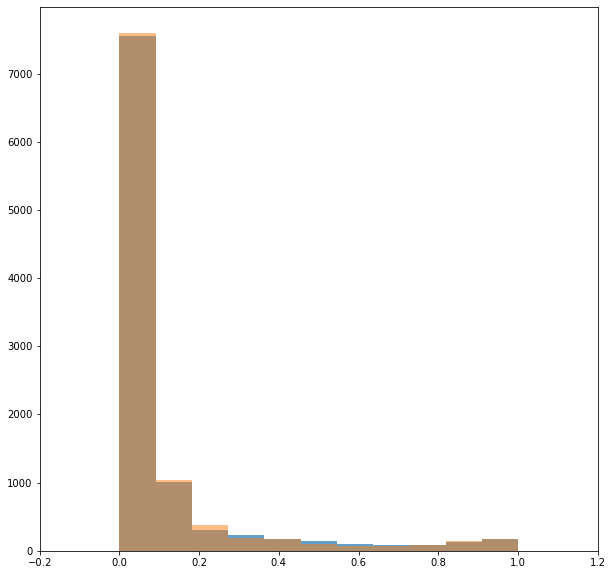

In [767]:
#Superposition des histogrammes
i = 3
plt.figure(figsize=(10,10))
bins = 12

#Original data (Blue)
plt.hist(img[:,i], bins=np.linspace(0, 1, num=bins), alpha = 0.7) #np.linspace(0,1,num=12)); #80

#Fitted data (Orange)
plt.hist(Samples[:,i], bins=np.linspace(0, 1, num=bins), alpha = 0.5) #np.linspace(0,1,num=12)); #120

plt.xlim([-0.2,1.2])
plt.show()

C'est une petite réussite. Nous pouvons encore améliorer les résultats en optimisant le nombre de clusters.

### Test 23/11/22: [Séléction de modèle (i.e nombre de clusters) selon le critère MDL] Lancement du EM Dirichlet sur Jasper selon différents nombres de clusters [8 à 16]

In [827]:
#On définit l'image
img = S_jasper[0].T #Image initiale
img = (img+0.001)/1.004 #Suppression des 0
img = img.detach().numpy()

In [672]:
#1e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_10, theta_10, eps_10, L10 = EM_dirichlet(img,10,100)
elapsed_10 = time.time() - t

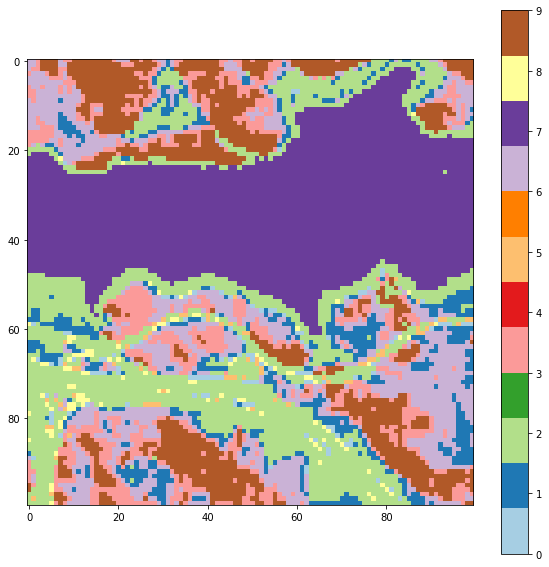

In [680]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_10,[100,100]), cmap='Paired');
plt.colorbar()

In [708]:
MDL_10 = MDL(L10[99], k=10, p=4, N=10000, proba_list=eps_10)

In [673]:
#2e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_11, theta_11, eps_11, L11 = EM_dirichlet(img,11,100)
elapsed_11 = time.time() - t

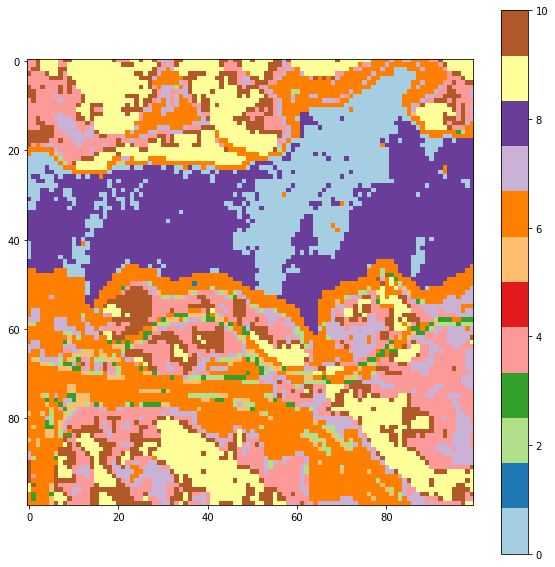

In [681]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_11,[100,100]), cmap='Paired');
plt.colorbar()

In [707]:
MDL_11 = MDL(L11[99], k=11, p=4, N=10000, proba_list=eps_11)

In [674]:
#3e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_13, theta_13, eps_13, L13 = EM_dirichlet(img,13,100)
elapsed_13 = time.time() - t

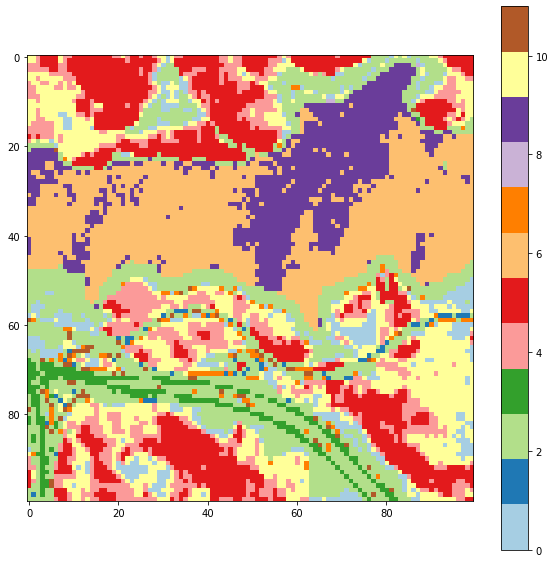

In [689]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_13,[100,100]), cmap='Paired');
plt.colorbar()

In [706]:
MDL_13 = MDL(L13[99], k=13, p=4, N=10000, proba_list=eps_13)

In [675]:
#4e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_14, theta_14, eps_14, L14 = EM_dirichlet(img,14,100)
elapsed_14 = time.time() - t

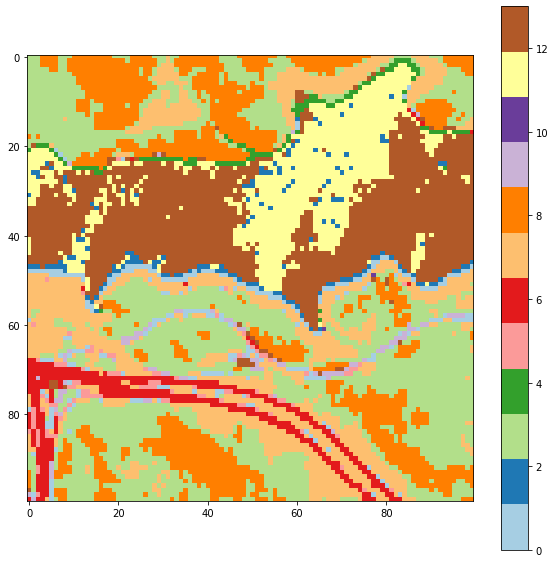

In [690]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_14,[100,100]), cmap='Paired');
plt.colorbar()

In [705]:
MDL_14 = MDL(L14[99], k=14, p=4, N=10000, proba_list=eps_14)

In [676]:
#5e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_15, theta_15, eps_15, L15 = EM_dirichlet(img,15,100)
elapsed_15 = time.time() - t

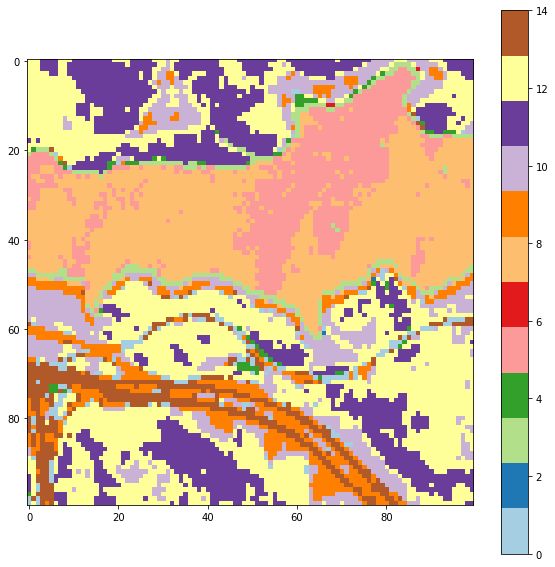

In [691]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_15,[100,100]), cmap='Paired');
plt.colorbar()

In [704]:
MDL_15 = MDL(L15[99], k=15, p=4, N=10000, proba_list=eps_15)

In [744]:
#6e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_8, theta_8, eps_8, L8 = EM_dirichlet(img,8,100)
elapsed_8 = time.time() - t

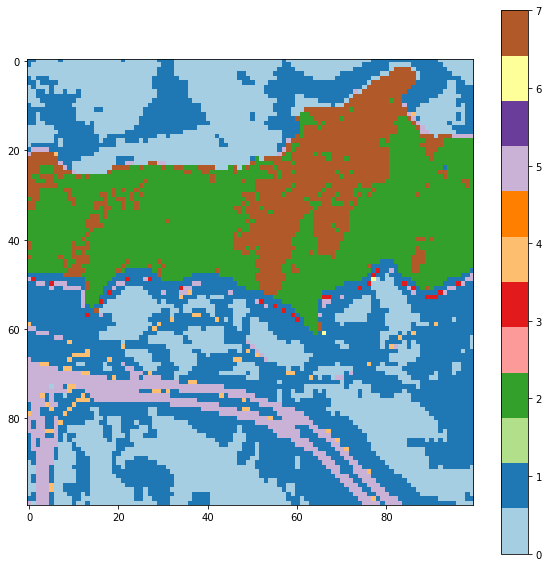

In [745]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_8,[100,100]), cmap='Paired');
plt.colorbar()

In [746]:
MDL_8 = MDL(L8[99], k=8, p=4, N=10000, proba_list=eps_8)

In [751]:
#7e modèle:


#Lancement de l'algo sur l'image
t = time.time()
beta_9, theta_9, eps_9, L9 = EM_dirichlet(img,9,100)
elapsed_9 = time.time() - t

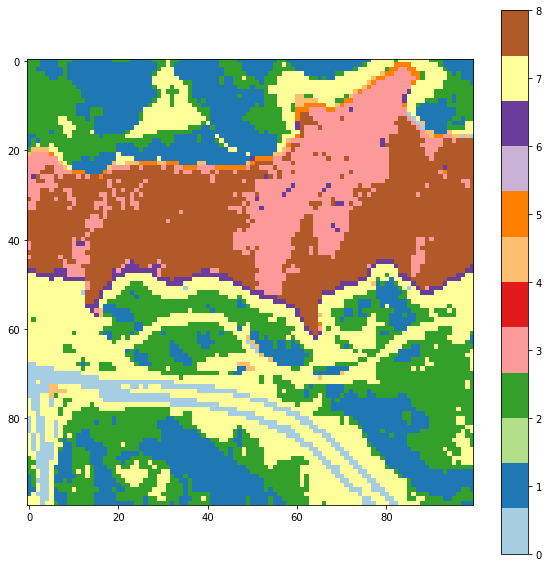

In [752]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_9,[100,100]), cmap='Paired');
plt.colorbar()

In [753]:
MDL_9 = MDL(L9[99], k=9, p=4, N=10000, proba_list=eps_9)

In [754]:
# On regroupe tout dans une liste et on compare
MDL_list= [MDL_5, MDL_8, MDL_9, MDL_10, MDL_11, MDL_13, MDL_14, MDL_15]

In [755]:
np.argmin(MDL_list)

0

#### Conclusion de la partie séléction de modèles avec le critère MDL:
Le meilleur modèle selon le critère de Minimum Description Length (MDL) est donc le modèle beta_5 qui correspond à k = 12 clusters.

### EM Dirichlet pour SAMSON:

In [803]:
#Chargement des données
mat = scipy.io.loadmat('samson_gt.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
#La ground truth
A_Samson = an_array[5,1]
S_Samson = an_array[4,1]

mat1 = scipy.io.loadmat('samson_1.mat')
data1 = list(mat1.items())
an_array1 = np.array(data1,dtype=object)
#L'image originale
X_Samson = an_array1[6,1] #De taille 95x95

In [840]:
#Mise à la bonne échelle
img_samson = S_Samson.T
img_samson = (img_samson+0.001)/1.003 #Suppression des 0
#np.sum(img_samson, axis=1) #! Vérifier si la somme fait bien 1

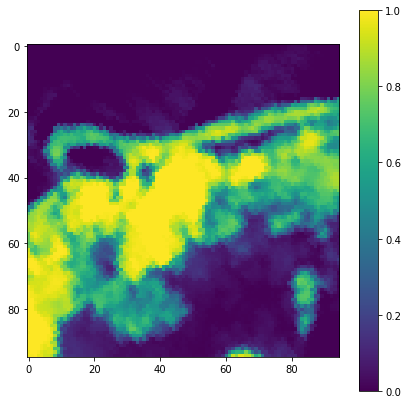

In [870]:
i=1
plt.figure(figsize=(7,7))
plt.imshow(np.reshape(S_Samson,(3,95,95))[i,:,:])
plt.colorbar()

In [842]:
#Lancement de l'algo sur l'image (k=8)
t = time.time()
beta_samson, theta_samson, eps_samson, Lsamson = EM_dirichlet(img_samson,8,100)
elapsed = time.time() - t

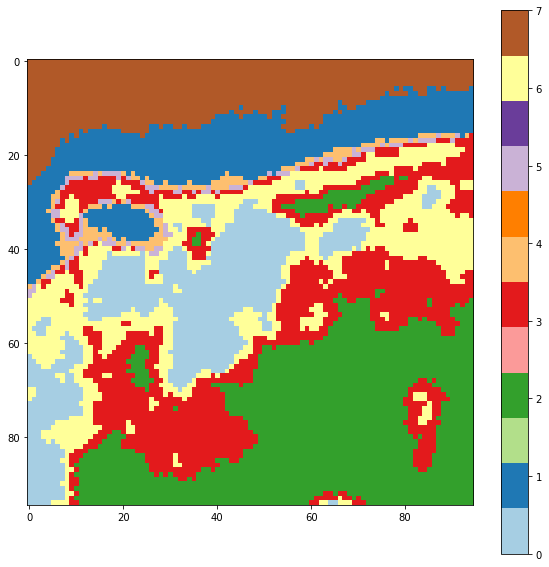

In [844]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_samson,[95,95]), cmap='Paired');
plt.colorbar()

In [863]:
MDL_samson = MDL(Lsamson[99], k=8, p=3, N=9025, proba_list=eps_samson)

In [871]:
eps_samson

array([0.13205243, 0.12233268, 0.24129023, 0.18718084, 0.01888313,
       0.01271258, 0.14945541, 0.1360927 ])

In [970]:
theta_samson

array([[ 0.60330514, 32.65955297,  0.31616308],
       [ 3.54583748,  0.39165915, 10.48946963],
       [14.60738504,  1.04699353,  0.38345853],
       [ 8.07210197,  9.43537876,  0.35494726],
       [17.90846706,  4.62227334, 15.32817447],
       [18.39763392, 15.85345466, 10.18199521],
       [ 4.54381057, 19.21862903,  0.28645229],
       [ 0.43481026,  0.29522029, 24.39660685]])

In [847]:
#Autre modèle k=7
t = time.time()
beta_samson7, theta_samson7, eps_samson7, Lsamson7 = EM_dirichlet(img_samson,7,100)
elapsed7 = time.time() - t

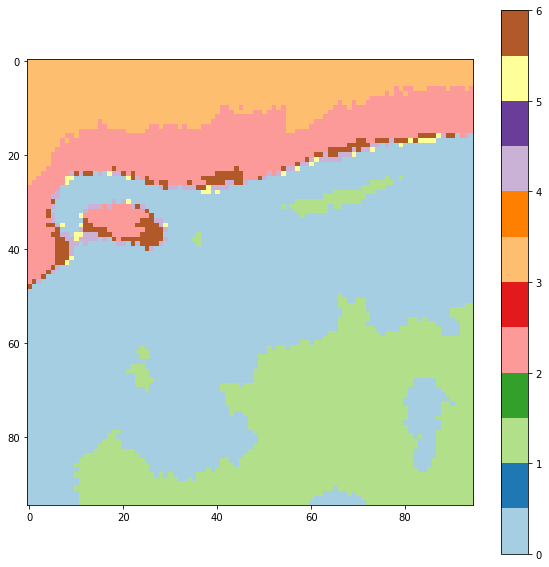

In [851]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_samson7,[95,95]), cmap='Paired');
plt.colorbar()

In [852]:
MDL_samson7 = MDL(Lsamson7[99], k=7, p=3, N=9025, proba_list=eps_samson7)

In [872]:
eps_samson7

array([0.48657938, 0.23149316, 0.12091066, 0.1325595 , 0.00864402,
       0.00478164, 0.01503165])

In [848]:
#Autre modèle k = 6
t = time.time()
beta_samson6, theta_samson6, eps_samson6, Lsamson6 = EM_dirichlet(img_samson,6,100)
elapsed6 = time.time() - t

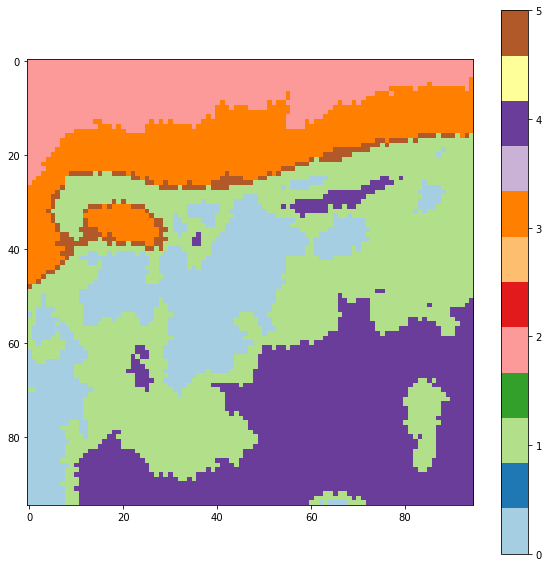

In [853]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_samson6,[95,95]), cmap='Paired');
plt.colorbar()

In [854]:
MDL_samson6 = MDL(Lsamson6[99], k=6, p=3, N=9025, proba_list=eps_samson6)

In [873]:
eps_samson6

array([0.16305901, 0.31830704, 0.12680067, 0.13310607, 0.23829181,
       0.0204354 ])

In [ ]:
#Autre modèle k = 9
t = time.time()
beta_samson9, theta_samson9, eps_samson9, Lsamson9 = EM_dirichlet(img_samson,9,100)
elapsed9 = time.time() - t

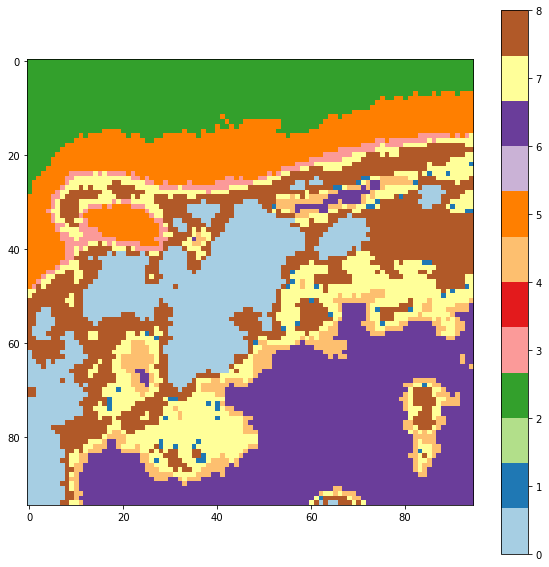

In [857]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_samson9,[95,95]), cmap='Paired');
plt.colorbar()

In [858]:
MDL_samson9 = MDL(Lsamson9[99], k=9, p=3, N=9025, proba_list=eps_samson9)

In [874]:
eps_samson9

array([0.1469321 , 0.05865446, 0.14813466, 0.02214063, 0.0551443 ,
       0.11299715, 0.20309742, 0.10113642, 0.15176285])

In [850]:
#Autre modèle k = 10
t = time.time()
beta_samson10, theta_samson10, eps_samson10, Lsamson10 = EM_dirichlet(img_samson,10,100)
elapsed10 = time.time() - t

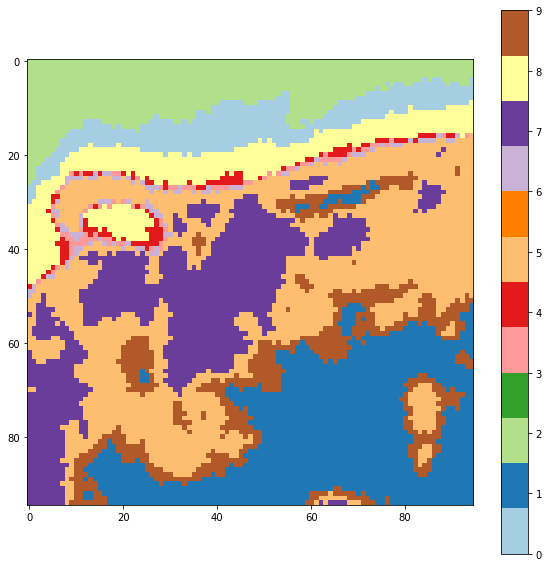

In [859]:
#Affichage des clusters estimés par EM Dirichlet
plt.figure(figsize=(10,10))
plt.imshow(np.reshape(beta_samson10,[95,95]), cmap='Paired');
plt.colorbar()

In [860]:
MDL_samson10 = MDL(Lsamson10[99], k=10, p=3, N=9025, proba_list=eps_samson10)

In [875]:
eps_samson10

array([0.06256834, 0.1883107 , 0.1196136 , 0.00947707, 0.01253509,
       0.26160911, 0.01137113, 0.1623144 , 0.0756695 , 0.09653107])

In [864]:
#Regroupement des scores MDL
MDL_samson_list = [MDL_samson, MDL_samson6, MDL_samson7, MDL_samson9, MDL_samson10]

In [868]:
#Sélection du modèle avec le score le plus bas
np.argmin(MDL_samson_list)

0

#### Conclusion de la séléction de modèle: Le modèle avec k=8 semble être le meilleur (cela dépend aussi des lancements). k=9 et k=10 semblent être bons de visu.

#### Superposition des histogrammes: (EM Dirichlet Samson)

In [960]:
#Superposition des histogrammes

#On transforme
proportion_samson = eps_samson*9025
proportion_samson = [int(x) for x in proportion_samson]
size_samples_samson = sum(proportion_samson)
proportion_samson, print(np.shape(eps_samson), size_samples_samson) #La proba associé à chaque gaussienne du mélange

(8,) 9021


([1191, 1104, 2177, 1689, 170, 114, 1348, 1228], None)

In [961]:
#Génération de Samples issus des lois estimées
Samples_samson = np.zeros((size_samples_samson,3))
k = proportion_samson[0]

for j in range(k):
    Samples_samson[j] = np.random.dirichlet(theta_samson[0])


position = 0
for i in range(1,8): #ici k =8 ! Attention à bien le changer
    
    position += proportion_samson[i-1]

    for j in range(position,position+proportion_samson[i]):
        Samples_samson[j] = np.random.dirichlet(theta_samson[i])

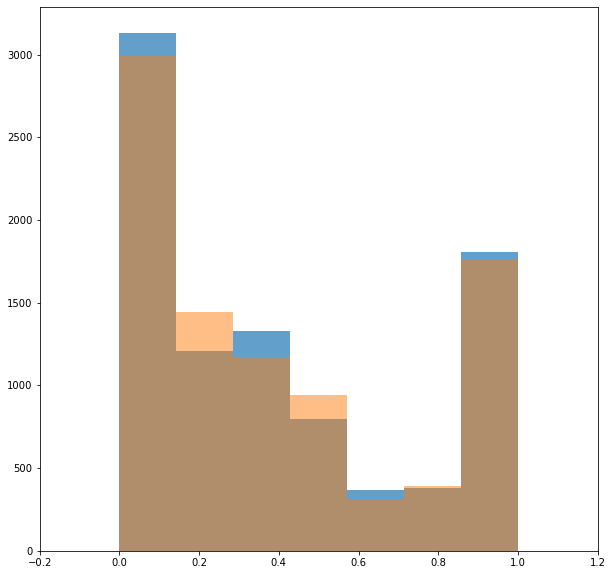

In [969]:
#Superposition des histogrammes
i = 0
plt.figure(figsize=(10,10))
bins = 8

#Original data (Blue)
plt.hist(img_samson[:,i], bins=np.linspace(0, 1, num=bins), alpha = 0.7) #np.linspace(0,1,num=12)); #80

#Fitted data (Orange)
plt.hist(Samples_samson[:,i], bins=np.linspace(0, 1, num=bins), alpha = 0.5) #np.linspace(0,1,num=12)); #120

plt.xlim([-0.2,1.2])
plt.show()

### [OBSOLETE] V) Advanced Samson Dirichlet: [OLD/ Tentative de modélisation des mixtures/ Remplacée par le nouveau EM sur toute l'image, qui fonctionne mieux et qui est 10x plus rapide]

#### V. a) Pixels où les 3 endmembers sont actifs (seuillés à >0.10)

In [57]:
#Chargement des données
mat = scipy.io.loadmat('all_active.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
all_active = np.transpose(an_array[3,1])
    
print(np.shape(all_active))

(293, 3)


In [61]:
alpha_hat(all_active)

[5.342845196426972, 3.9772466165665494, 3.4134227768708145]

In [27]:
#2 modes:
t = time.time()
theta_aa2, eps_aa2, Ld_aa2 = EM_dirichlet(all_active,2,2000)
elapsed = time.time() - t
print(elapsed)

130.35110449790955


In [28]:
theta_aa2

array([[13.21996801,  5.64058609, 10.59131131],
       [12.52483713, 15.27324681,  6.11081415]])

In [29]:
eps_aa2

array([0.48231625, 0.51768375])

In [58]:
#3 modes:
t = time.time()
theta_aa3, eps_aa3, Ld_aa3 = EM_dirichlet(all_active,3,2000)
elapsed = time.time() - t
print(elapsed)

189.57929134368896


In [59]:
theta_aa3

array([[ 32.51870719, 119.12873365,  21.21090903],
       [ 19.25150635,  21.67567521,   8.97622911],
       [ 13.25907267,   5.6750398 ,  10.64303426]])

In [60]:
eps_aa3

array([0.0382722 , 0.47588092, 0.48584688])

#### V. b) Pixels où seulement 2 EM sont actifs

#### EM 1-2:

In [10]:
#Chargement des données
mat = scipy.io.loadmat('two_12.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_12 = np.transpose(an_array[29,1])

np.shape(two_12)

(3378, 2)

In [34]:
#1 mode:
alpha_hat(two_12)

[1.8319106697023073, 2.196128310295089]

In [11]:
#2 modes:
t = time.time()
theta_two122, eps_two122, Ld_two122 = EM_dirichlet(two_12,2,600)
elapsed = time.time() - t
print(elapsed)

439.2664997577667


In [17]:
theta_two122

array([[ 3.04709379,  5.69047286],
       [21.30016822,  5.02814588]])

In [18]:
eps_two122

array([0.79151824, 0.20848176])

In [12]:
#3 modes:
t = time.time()
theta_two123, eps_two123, Ld_two123 = EM_dirichlet(two_12,3,600)
elapsed = time.time() - t
print(elapsed)

620.4748458862305


In [19]:
theta_two123

array([[ 4.4449205 , 11.84949236],
       [ 6.34648535,  5.13947285],
       [54.39562542,  9.59179073]])

In [20]:
eps_two123

array([0.53804018, 0.32125891, 0.14070091])

#### EM 1-3:

In [26]:
#Chargement des données
mat = scipy.io.loadmat('two_13.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_13 = np.transpose(an_array[30,1])

np.shape(two_13)

(1076, 2)

In [33]:
#1 mode:
alpha_hat(two_13)

[3.446952458853036, 8.380302172675952]

In [27]:
#2 modes:
t = time.time()
theta_two132, eps_two132, Ld_two132 = EM_dirichlet(two_13,2,600)
elapsed = time.time() - t
print(elapsed)

139.70470643043518


In [28]:
theta_two132

array([[ 8.25187014, 13.57211777],
       [ 8.09547274, 37.58719843]])

In [29]:
eps_two132

array([0.56897816, 0.43102184])

In [30]:
#3 modes:
t = time.time()
theta_two133, eps_two133, Ld_two133 = EM_dirichlet(two_13,3,600)
elapsed = time.time() - t
print(elapsed)

200.91608214378357


In [31]:
theta_two133

array([[ 8.57088352, 40.16606647],
       [ 8.6658794 , 14.22073531],
       [ 9.07823433, 14.81887449]])

In [32]:
eps_two133

array([0.43028708, 0.56677713, 0.0029358 ])

In [70]:
#Génération du jeu de données avec 3 EM actifs:
sa1 = np.random.dirichlet((13.22,5.64,10.6),141)
sa2 = np.random.dirichlet((12.52,15.27,6.11),154)
sa = np.concatenate((sa1,sa1),axis=0)

np.shape(sa)

(282, 3)

In [47]:
#Génération du jeu de données EM 1-2
s1 = np.random.dirichlet((3.05,5.70),2668)
s2 = np.random.dirichlet((21.3,5.03),709)
s12 = np.concatenate((np.concatenate((s1,s2),axis=0),np.zeros((2668+709,1))),axis=1)

np.shape(s12)

(3377, 3)

In [53]:
#Génération du jeu de données EM 1-3
s1 = np.random.dirichlet((8.25,13.57),614)
s3 = np.random.dirichlet((8.10,37.6),463)
s13 = np.concatenate((np.concatenate((s1,s3),axis=0),np.zeros((614+463,1))),axis=1)
s13[:,2] = s13[:,1]
s13[:,1] = 0

np.shape(s13)

(1077, 3)

In [86]:
#Génération des jeux avec pixels purs
pp1 = np.concatenate((np.ones((1499,1)),np.zeros((1499,2))),axis=1)
pp2 = np.concatenate((np.zeros((1365,1)),np.ones((1365,1))),axis=1)
pp2 = np.concatenate((pp2,np.zeros((1365,1))),axis=1)
pp3 = np.concatenate((np.zeros((1264,2)),np.ones((1264,1))),axis=1)

pp = np.concatenate((pp1,pp2),axis=0)
pp = np.concatenate((pp,pp3),axis=0)

In [89]:
#Concatenation de l'ensemble des jeux de données
dataset = np.concatenate((pp,sa),axis=0)
dataset = np.concatenate((dataset,s12),axis=0)
dataset = np.concatenate((dataset,s13),axis=0)

np.shape(dataset)

(8864, 3)

In [450]:
#Comparaison avec le jeu de données initiales
#Chargement
mat = scipy.io.loadmat('ds.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
original = np.transpose(an_array[3,1])
    
print(np.shape(original))

(9025, 3)


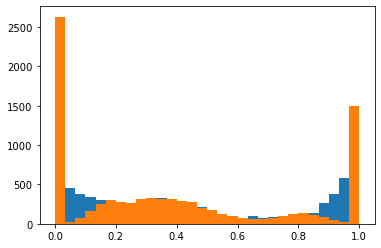

In [451]:
#Comparaison des histogrammes:
plt.hist(np.transpose(original)[0], bins=30)  # arguments are passed to np.histogram
plt.hist(np.transpose(dataset)[0], bins=30) 
plt.show()

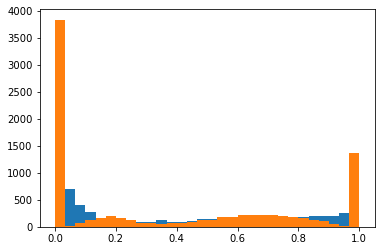

In [149]:
plt.hist(np.transpose(original)[1], bins=30)  # arguments are passed to np.histogram
plt.hist(np.transpose(dataset)[1], bins=30) 
plt.show()

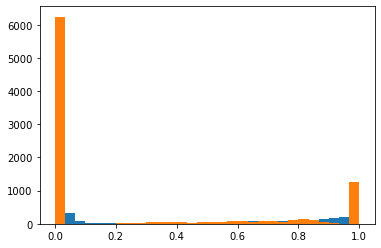

In [151]:
plt.hist(np.transpose(original)[2], bins=30)  # arguments are passed to np.histogram
plt.hist(np.transpose(dataset)[2], bins=30) 
plt.show()

### [OBSOLETE] VI) Adavanced Jasper Dirichlet [OLD/ Tentative de modélisation des mixtures/ Remplacée par le nouveau EM sur toute l'image, qui fonctionne mieux et qui est 10x plus rapide]

#### a) all active

In [10]:
#Chargement des données
mat = scipy.io.loadmat('all_active.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
all_active = np.transpose(an_array[5,1])

print(np.shape(all_active))

(63, 4)


In [11]:
#1 mode:
theta_aa = alpha_hat(all_active)
print(theta_aa)

[2.5431879561001884, 1.3020024843156586, 4.0178316405353725, 1.9675968724393185]


In [168]:
#2 modes:
t = time.time()
theta_aa2, eps_aa2, Ld_aa2 = EM_dirichlet(all_active,2,2000)
elapsed = time.time() - t
print(elapsed)
print(theta_aa2, eps_aa2)

29.998170137405396
[[ 2.53208741  1.17979668  2.24725711  1.8584554 ]
 [ 5.69720957  2.78764952 16.29761016  4.46572221]] [0.45318025 0.54681975]


In [169]:
#3 modes:
t = time.time()
theta_aa3, eps_aa3, Ld_aa3 = EM_dirichlet(all_active,3,2000)
elapsed = time.time() - t
print(elapsed)
print(theta_aa3, eps_aa3)

44.81323957443237
[[18.91230459  4.38654494 21.83641849  7.52971128]
 [ 6.11184555  3.87557922 25.83937318  6.10349951]
 [ 1.9359257   1.18025502  1.66396849  1.94799702]] [0.34472067 0.36552794 0.28975139]


#### b.1) 123

In [177]:
#Chargement des données
mat = scipy.io.loadmat('three_123.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
three_123 = np.transpose(an_array[3,1])

np.shape(three_123)

(155, 3)

In [179]:
#1 mode:
theta_123 = alpha_hat(three_123)
print(theta_123)

[1.0511883542879483, 1.3152238061906323, 1.7918637851590442]


In [250]:
#2 modes:
t = time.time()
theta_123_2, eps_123_2, Ld_123_2 = EM_dirichlet(three_123,2,600)
elapsed = time.time() - t

print(elapsed)
print(theta_123_2, eps_123_2)

25.922680377960205
[[ 2.9656119  24.09591528  5.11981586]
 [ 1.99864603  1.47440792  4.03830448]] [0.28666507 0.71333493]


In [251]:
#3 modes:
t = time.time()
theta_123_3, eps_123_3, Ld_123_3 = EM_dirichlet(three_123,3,600)
elapsed = time.time() - t

print(elapsed)
print(theta_123_3, eps_123_3)

38.09740471839905
[[ 2.77891632 21.50391628  4.83765056]
 [13.09380978  3.89077703  5.03451785]
 [ 2.36294462  1.77408721  6.13911643]] [0.30444149 0.08137126 0.61418725]


#### b.2) 124

In [185]:
#Chargement des données
mat = scipy.io.loadmat('three_124.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
three_124 = np.transpose(an_array[40,1])

#np.shape(an_array)
np.shape(three_124)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(277, 3)

In [186]:
#1 mode:
theta_124 = alpha_hat(three_124)
print(theta_124)

[0.9715455872905046, 3.113974937220939, 1.0839440016176647]


In [187]:
#2 modes:
t = time.time()
theta_124_2, eps_124_2, Ld_124_2 = EM_dirichlet(three_124,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_124_2, eps_124_2)

37.11898636817932
[[ 8.28180132 97.47228969 12.06889257]
 [ 1.64014806  1.72572608  1.47841586]] [0.63899175 0.36100825]


In [188]:
#3 modes:
t = time.time()
theta_124_3, eps_124_3, Ld_124_3 = EM_dirichlet(three_124,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_124_3, eps_124_3)

53.98534321784973
[[  1.92208295   1.42600556   1.73567619]
 [  4.41155111  17.99367216   4.07348537]
 [  9.62246808 119.13093791  14.31358073]] [0.25598051 0.14825869 0.5957608 ]


#### b.3) 134

In [194]:
#Chargement des données
mat = scipy.io.loadmat('three_134.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
three_134 = np.transpose(an_array[41,1])

#np.shape(an_array)
np.shape(three_134)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(765, 3)

In [195]:
#1 mode:
theta_134 = alpha_hat(three_134)
print(theta_134)

[1.6674114777707976, 2.4362447048155462, 1.6915684682535024]


In [196]:
#2 modes:
t = time.time()
theta_134_2, eps_134_2, Ld_134_2 = EM_dirichlet(three_134,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_134_2, eps_134_2)

100.07110476493835
[[ 4.37395808 23.20219612  3.99750043]
 [ 1.75629668  2.33979302  1.79801592]] [0.09125748 0.90874252]


In [197]:
#3 modes:
t = time.time()
theta_134_3, eps_134_3, Ld_134_3 = EM_dirichlet(three_134,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_134_3, eps_134_3)

148.37894940376282
[[ 7.05901792 50.31554405  6.9457842 ]
 [ 1.92155279  2.65455262  1.82356839]
 [ 4.36106333  5.45587133 31.09180946]] [0.06339332 0.89452872 0.04207796]


#### b.4) 234

In [198]:
#Chargement des données
mat = scipy.io.loadmat('three_234.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
three_234 = np.transpose(an_array[42,1])

#np.shape(an_array)
np.shape(three_234)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(120, 3)

In [199]:
#1 mode:
theta_234 = alpha_hat(three_234)
print(theta_234)

[1.152743541080909, 1.6745124779693832, 1.6277930033618973]


In [200]:
#2 modes:
t = time.time()
theta_234_2, eps_234_2, Ld_234_2 = EM_dirichlet(three_234,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_234_2, eps_234_2)

15.961499214172363
[[ 17.09066876  11.88842002 128.65503671]
 [  1.55747719   2.71565125   1.74971204]] [0.1775852 0.8224148]


In [201]:
#3 modes:
t = time.time()
theta_234_3, eps_234_3, Ld_234_3 = EM_dirichlet(three_234,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_234_3, eps_234_3)

23.569109439849854
[[ 16.47410091  11.47284439 122.78055966]
 [105.533165     8.98355118   8.52594715]
 [  2.039295     4.88383842   2.80978903]] [0.18261149 0.06633503 0.75105348]


#### c.1) 12

In [205]:
#Chargement des données
mat = scipy.io.loadmat('two_12.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_12 = np.transpose(an_array[45,1])

#np.shape(an_array)
np.shape(two_12)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(159, 2)

In [206]:
#1 mode:
theta_12 = alpha_hat(two_12)
print(theta_12)

[0.6013226783662863, 1.1951640708468172]


In [208]:
#2 modes:
t = time.time()
theta_12_2, eps_12_2, Ld_12_2 = EM_dirichlet(two_12,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_12_2, eps_12_2)

20.859001636505127
[[ 10.29322157 140.64737462]
 [  1.82698569   1.06249552]] [0.58868728 0.41131272]


In [209]:
#3 modes:
t = time.time()
theta_12_3, eps_12_3, Ld_12_3 = EM_dirichlet(two_12,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_12_3, eps_12_3)

30.735955715179443
[[  2.64800774   5.36037499]
 [ 11.50430111   2.29056876]
 [ 10.56088008 145.59142724]] [0.16962915 0.24911818 0.58125267]


#### c.2) 13

In [219]:
#Chargement des données
mat = scipy.io.loadmat('two_13.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_13 = np.transpose(an_array[3,1])

#np.shape(an_array)
np.shape(two_13)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(3143, 2)

In [222]:
#1 mode:
theta_13 = alpha_hat(two_13)
print(theta_13)

[2.316495372784449, 1.8341522592808026]


In [220]:
#2 modes:
t = time.time()
theta_13_2, eps_13_2, Ld_13_2 = EM_dirichlet(two_13,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_13_2, eps_13_2)

409.0247611999512
[[4.26205169 2.19874279]
 [2.25072416 3.94024884]] [0.67128974 0.32871026]


In [225]:
#3 modes:
t = time.time()
theta_13_3, eps_13_3, Ld_13_3 = EM_dirichlet(two_13,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_13_3, eps_13_3)

762.8918647766113
[[ 3.14628211 12.22237758]
 [13.33584707  3.03734957]
 [ 6.49221073  5.72771503]] [0.13977773 0.27014142 0.59008085]


#### c.3) 14

In [226]:
#Chargement des données
mat = scipy.io.loadmat('two_14.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_14 = np.transpose(an_array[47,1])

#np.shape(an_array)
np.shape(two_14)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(71, 2)

In [231]:
#1 mode:
theta_14 = alpha_hat(two_14)
print(theta_14)

[1.7475443468881913, 0.9095846334425132]


In [228]:
#2 modes:
t = time.time()
theta_14_2, eps_14_2, Ld_14_2 = EM_dirichlet(two_14,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_14_2, eps_14_2)

12.676965951919556
[[ 1.35680501  1.76769133]
 [41.02614127  4.93515637]] [0.43471632 0.56528368]


In [229]:
#3 modes:
t = time.time()
theta_14_3, eps_14_3, Ld_14_3 = EM_dirichlet(two_14,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_14_3, eps_14_3)

14.070831060409546
[[ 2.38967442 11.23529042]
 [53.34163233  5.86123156]
 [ 8.07838848  3.82102415]] [0.19740064 0.51977896 0.28282041]


#### c.4) 23

In [232]:
#Chargement des données
mat = scipy.io.loadmat('two_23.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_23 = np.transpose(an_array[48,1])

#np.shape(an_array)
np.shape(two_23)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(249, 2)

In [233]:
#1 mode:
theta_23 = alpha_hat(two_23)
print(theta_23)

[3.916802658743266, 1.1748392548563171]


In [234]:
#2 modes:
t = time.time()
theta_23_2, eps_23_2, Ld_23_2 = EM_dirichlet(two_23,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_23_2, eps_23_2)

32.17965793609619
[[ 3.60971467  1.95190966]
 [84.15769179  7.31863079]] [0.52662497 0.47337503]


In [235]:
#3 modes:
t = time.time()
theta_23_3, eps_23_3, Ld_23_3 = EM_dirichlet(two_23,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_23_3, eps_23_3)

47.67291307449341
[[ 76.90146955   6.80528311]
 [  5.50224559   2.81849835]
 [ 13.44349446 218.32998523]] [0.49957875 0.48837868 0.01204256]


#### c.5) 24

In [239]:
#Chargement des données
mat = scipy.io.loadmat('two_24.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_24 = np.transpose(an_array[49,1])

#np.shape(an_array)
np.shape(two_24)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(903, 2)

In [241]:
#1 mode:
theta_24 = alpha_hat(two_24)
print(theta_24)

[4.051051954871735, 1.0008269297924242]


In [242]:
#2 modes:
t = time.time()
theta_24_2, eps_24_2, Ld_24_2 = EM_dirichlet(two_24,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_24_2, eps_24_2)

117.08070158958435
[[ 1.30704607  6.30016511]
 [57.7669239   7.2193044 ]] [0.06309664 0.93690336]


In [243]:
#3 modes:
t = time.time()
theta_24_3, eps_24_3, Ld_24_3 = EM_dirichlet(two_24,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_24_3, eps_24_3)

170.61832356452942
[[  4.98707052   3.81560071]
 [ 10.53336979 108.26169084]
 [ 59.41327381   7.38685183]] [0.01470599 0.05210134 0.93319268]


#### c.6) 34

In [246]:
#Chargement des données
mat = scipy.io.loadmat('two_34.mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
two_34 = np.transpose(an_array[50,1])

#np.shape(an_array)
np.shape(two_34)
#for i in range(53):
#    print(i, np.shape(an_array[i,1]))

(704, 2)

In [247]:
#1 mode:
theta_34 = alpha_hat(two_34)
print(theta_34)

[1.6956763030202915, 1.3111300348092092]


In [248]:
#2 modes:
t = time.time()
theta_34_2, eps_34_2, Ld_34_2 = EM_dirichlet(two_34,2,600)
elapsed = time.time() - t
print(elapsed)
print(theta_34_2, eps_34_2)

115.66446685791016
[[8.41404809 2.42363924]
 [1.98193275 4.24127539]] [0.55848181 0.44151819]


In [249]:
#3 modes:
t = time.time()
theta_34_3, eps_34_3, Ld_34_3 = EM_dirichlet(two_34,3,600)
elapsed = time.time() - t
print(elapsed)
print(theta_34_3, eps_34_3)

169.16521096229553
[[35.83888051  4.94046389]
 [ 2.36310651  7.25206368]
 [ 7.24861113  3.78915807]] [0.23247927 0.32640398 0.44111674]


#### d) Création d'un jeu de données à partir des estimations

In [58]:
#Génération du jeu de données 
def generate_ds(x=1):
    #saa_1 = np.random.dirichlet((18.91,4.39,21.84,7.53),int(0.34*63)+10)
    #saa_2 = np.random.dirichlet((6.11,3.88,25.84,6.10),int(0.37*63)+10)
    #saa_3 = np.random.dirichlet((1.94,1.8,1.66,1.95),int(0.29*63)+11)
    saa_1 = np.random.dirichlet((18.91,4.39,21.84,7.53),int(0.34*63))
    saa_2 = np.random.dirichlet((6.11,3.88,25.84,6.10),int(0.37*63))
    saa_3 = np.random.dirichlet((1.94,1.8,1.66,1.95),int(0.29*63))
    
    saa = np.concatenate((np.concatenate((saa_1,saa_2),axis=0),saa_3),axis=0)

#np.shape(saa)

    s123_1 = np.random.dirichlet((2.97,24.10,5.12),int(0.29*155)+1)
    s123_2 = np.random.dirichlet((1.99,1.47,4.04),int(0.71*155))

    s123 = np.concatenate((s123_1,s123_2),axis=0)
    s123 = np.concatenate((s123,np.zeros((155,1))),axis=1)

#np.shape(s123)
    ds = np.concatenate((saa,s123),axis=0)
#np.shape(ds)

    #s124_1 = np.random.dirichlet((1.92,1.43,1.74),int(0.25*277)+20)
    s124_1 = np.random.dirichlet((1.92,1.43,1.74),int(0.25*277))
    s124_2 = np.random.dirichlet((4.41,17.99,4.07),int(0.15*277)+1)
    s124_3 = np.random.dirichlet((9.62,119.13,14.31),int(0.60*277))

    s124 = np.concatenate((s124_1,s124_2),axis=0)
    s124 = np.concatenate((s124,s124_3),axis=0)
    s124 = np.concatenate((s124,np.zeros((277,1))),axis=1)

    s124[:,3] = s124[:,2]
    s124[:,2] = 0

#np.shape(s124)
    ds = np.concatenate((ds,s124),axis=0)
#np.shape(ds)

    s134 = np.random.dirichlet((1.66,2.44,1.69),765)
    s134 = np.concatenate((s134,np.zeros((765,1))),axis=1)
    tmp1 = s134[:,1]
    tmp2 = s134[:,2]
    s134[:,1] = 0 
    s134[:,2] = tmp1
    s134[:,3] = tmp2

#np.shape(s134)

    ds = np.concatenate((ds,s134),axis=0)
#np.shape(ds)

    s234_1 = np.random.dirichlet((17.09,11.88,128.66),int(0.18*120)+1)
    s234_2 = np.random.dirichlet((1.56,2.72,1.75),int(0.82*120))

    s234 = np.concatenate((s234_1,s234_2),axis=0)
    s234 = np.concatenate((np.zeros((120,1)),s234),axis=1)
    

#np.shape(s234)
    ds = np.concatenate((ds,s234),axis=0)
#np.shape(ds)

    s12_1 = np.random.dirichlet((2.65,5.36),int(0.17*159))
    s12_2 = np.random.dirichlet((11.5,2.29),int(0.25*159)+1)
    #s12_3 = np.random.dirichlet((10.56,145.59),int(0.58*159)+10)
    
    s12_3 = np.random.dirichlet((10.56,145.59),int(0.58*159))

    s12 = np.concatenate((np.concatenate((s12_1,s12_2),axis=0),s12_3),axis=0)
    s12 = np.concatenate((s12,np.zeros((159,2))),axis=1)

#np.shape(s12)
    ds = np.concatenate((ds,s12),axis=0)
#np.shape(ds)

    s13_1 = np.random.dirichlet((3.15,12.22),int(0.14*3143)+1)
    #s13_2 = np.random.dirichlet((13.34,3.04),int(0.27*3143)+20)
    s13_2 = np.random.dirichlet((13.34,3.04),int(0.27*3143))
    s13_3 = np.random.dirichlet((6.49,5.72),int(0.59*3143))

    s13 = np.concatenate((np.concatenate((s13_1,s13_2),axis=0),s13_3),axis=0)
    s13 = np.concatenate((s13,np.zeros((3143,2))),axis=1)
    s13[:,2] = s13[:,1]
    s13[:,1] = 0

#np.shape(s13)
    ds = np.concatenate((ds,s13),axis=0)
#np.shape(ds)

    s14_1 = np.random.dirichlet((2.39,11.24),int(0.2*71)+1)
    s14_2 = np.random.dirichlet((53.34,5.86),int(0.52*71))
    s14_3 = np.random.dirichlet((8.07,3.82),int(0.28*71)+1)

    s14 = np.concatenate((np.concatenate((s14_1,s14_2),axis=0),s14_3),axis=0)
    s14 = np.concatenate((s14,np.zeros((71,2))),axis=1)
    s14[:,3] = s14[:,1]
    s14[:,1] = 0

#np.shape(s14)
    ds = np.concatenate((ds,s14),axis=0)
#np.shape(ds)

    s23_1 = np.random.dirichlet((3.61,1.95),int(0.53*249))
    s23_2 = np.random.dirichlet((84.16,7.32),int(0.47*249)+1)

    s23 = np.concatenate((s23_1,s23_2),axis=0)
    s23 = np.concatenate((np.zeros((249,1)),s23),axis=1)
    s23 = np.concatenate((s23,np.zeros((249,1))),axis=1)

#np.shape(s23)
    ds = np.concatenate((ds,s23),axis=0)
#np.shape(ds)

    s24_1 = np.random.dirichlet((4.05,1),903)

    s24 = np.zeros((903,4))
    s24[:,3] = s24_1[:,1]
    s24[:,1] = s24_1[:,0]

#np.shape(s24)
    ds = np.concatenate((ds,s24),axis=0)
#np.shape(ds)

    s34_1 = np.random.dirichlet((35.84,4.94),int(0.23*704)+1)
    s34_2 = np.random.dirichlet((2.36,7.25),int(0.33*704)+1)
    s34_3 = np.random.dirichlet((7.25,3.79),int(0.44*704))

    s34 = np.concatenate((s34_1,s34_2),axis=0)
    s34 = np.concatenate((s34,s34_3),axis=0)

    s34 = np.concatenate((np.zeros((704,2)),s34),axis=1)

#np.shape(s34)
    ds = np.concatenate((ds,s34),axis=0)
#np.shape(ds)

    pp1 = np.zeros((1204,4))
    pp1[:,0] = 1

    ds = np.concatenate((ds,pp1),axis=0)

    pp2 = np.zeros((1650,4))
    pp2[:,1] = 1

    ds = np.concatenate((ds,pp2),axis=0)

    pp3 = np.zeros((160,4))
    pp3[:,2] = 1

    ds = np.concatenate((ds,pp3),axis=0)

    pp4 = np.zeros((135,4))
    pp4[:,3] = 1

    ds = np.concatenate((ds,pp4),axis=0)

    return ds

In [59]:
ds = generate_ds(x=1)
np.shape(ds)

(9757, 4)

In [19]:
saa_1 = np.random.dirichlet((18.91,4.39,21.84,7.53),int(0.34*63))
saa_2 = np.random.dirichlet((6.11,3.88,25.84,6.10),int(0.37*63))
saa_3 = np.random.dirichlet((1.94,1.8,1.66,1.95),int(0.29*63))
    
saa = np.concatenate((np.concatenate((saa_1,saa_2),axis=0),saa_3),axis=0)

np.shape(saa)

(62, 4)

In [57]:
s123_1 = np.random.dirichlet((2.97,24.10,5.12),int(0.29*155)+1)
s123_2 = np.random.dirichlet((1.99,1.47,4.04),int(0.71*155))

s123 = np.concatenate((s123_1,s123_2),axis=0)
s123 = np.concatenate((s123,np.zeros((155,1))),axis=1)

np.shape(s123)
#ds = np.concatenate((saa,s123),axis=0)
#print(s123)
#print(sum(s123[:,0]<0.05), sum(s123[:,1]<0.05), sum(s123[:,2]<0.05))
#print(s123[0:100,:])

(155, 4)

In [44]:
s124_1 = np.random.dirichlet((1.92,1.43,1.74),int(0.25*277))
s124_2 = np.random.dirichlet((4.41,17.99,4.07),int(0.15*277)+1)
s124_3 = np.random.dirichlet((9.62,119.13,14.31),int(0.60*277))

s124 = np.concatenate((s124_1,s124_2),axis=0)
s124 = np.concatenate((s124,s124_3),axis=0)
s124 = np.concatenate((s124,np.zeros((277,1))),axis=1)

s124[:,3] = s124[:,2]
s124[:,2] = 0

np.shape(s124)
#ds = np.concatenate((ds,s124),axis=0)
#np.shape(ds)
print(sum(s124[:,0]<0.05), sum(s124[:,1]<0.05), sum(s124[:,3]<0.05))

40 3 3


In [22]:
s134 = np.random.dirichlet((1.66,2.44,1.69),765)
s134 = np.concatenate((s134,np.zeros((765,1))),axis=1)
tmp1 = s134[:,1]
tmp2 = s134[:,2]
s134[:,1] = 0 
s134[:,2] = tmp1
s134[:,3] = tmp2

np.shape(s134)

#ds = np.concatenate((ds,s134),axis=0)
#np.shape(ds)

(765, 4)

In [23]:
s234_1 = np.random.dirichlet((17.09,11.88,128.66),int(0.18*120)+1)
s234_2 = np.random.dirichlet((1.56,2.72,1.75),int(0.82*120))

s234 = np.concatenate((s234_1,s234_2),axis=0)
s234 = np.concatenate((np.zeros((120,1)),s234),axis=1)
    

np.shape(s234)
#ds = np.concatenate((ds,s234),axis=0)
#np.shape(ds)

(120, 4)

In [27]:
s12_1 = np.random.dirichlet((2.65,5.36),int(0.17*159))
s12_2 = np.random.dirichlet((11.5,2.29),int(0.25*159)+1)
    #s12_3 = np.random.dirichlet((10.56,145.59),int(0.58*159)+10)
    
s12_3 = np.random.dirichlet((10.56,145.59),int(0.58*159))

s12 = np.concatenate((np.concatenate((s12_1,s12_2),axis=0),s12_3),axis=0)
s12 = np.concatenate((s12,np.zeros((159,2))),axis=1)

np.shape(s12)
#ds = np.concatenate((ds,s12),axis=0)
#np.shape(ds)

(159, 4)

In [26]:
s13_1 = np.random.dirichlet((3.15,12.22),int(0.14*3143)+1)
    #s13_2 = np.random.dirichlet((13.34,3.04),int(0.27*3143)+20)
s13_2 = np.random.dirichlet((13.34,3.04),int(0.27*3143))
s13_3 = np.random.dirichlet((6.49,5.72),int(0.59*3143))

s13 = np.concatenate((np.concatenate((s13_1,s13_2),axis=0),s13_3),axis=0)
s13 = np.concatenate((s13,np.zeros((3143,2))),axis=1)
s13[:,2] = s13[:,1]
s13[:,1] = 0

np.shape(s13)
#ds = np.concatenate((ds,s13),axis=0)
#np.shape(ds)

(3143, 4)

In [29]:
s14_1 = np.random.dirichlet((2.39,11.24),int(0.2*71)+1)
s14_2 = np.random.dirichlet((53.34,5.86),int(0.52*71))
s14_3 = np.random.dirichlet((8.07,3.82),int(0.28*71)+1)

s14 = np.concatenate((np.concatenate((s14_1,s14_2),axis=0),s14_3),axis=0)
s14 = np.concatenate((s14,np.zeros((71,2))),axis=1)
s14[:,3] = s14[:,1]
s14[:,1] = 0

np.shape(s14)
#ds = np.concatenate((ds,s14),axis=0)
#np.shape(ds)

(71, 4)

In [30]:
s23_1 = np.random.dirichlet((3.61,1.95),int(0.53*249))
s23_2 = np.random.dirichlet((84.16,7.32),int(0.47*249)+1)

s23 = np.concatenate((s23_1,s23_2),axis=0)
s23 = np.concatenate((np.zeros((249,1)),s23),axis=1)
s23 = np.concatenate((s23,np.zeros((249,1))),axis=1)

np.shape(s23)
#ds = np.concatenate((ds,s23),axis=0)
#np.shape(ds)

(249, 4)

In [31]:
s24_1 = np.random.dirichlet((4.05,1),903)

s24 = np.zeros((903,4))
s24[:,3] = s24_1[:,1]
s24[:,1] = s24_1[:,0]

np.shape(s24)
#ds = np.concatenate((ds,s24),axis=0)
#np.shape(ds)

(903, 4)

In [32]:
s34_1 = np.random.dirichlet((35.84,4.94),int(0.23*704)+1)
s34_2 = np.random.dirichlet((2.36,7.25),int(0.33*704)+1)
s34_3 = np.random.dirichlet((7.25,3.79),int(0.44*704))

s34 = np.concatenate((s34_1,s34_2),axis=0)
s34 = np.concatenate((s34,s34_3),axis=0)

s34 = np.concatenate((np.zeros((704,2)),s34),axis=1)

np.shape(s34)
#ds = np.concatenate((ds,s34),axis=0)
#np.shape(ds)

(704, 4)

#### Comparaison des jeux de données

In [14]:
#Chargement des données
#mat = scipy.io.loadmat('original_jasper_A.mat')
mat = scipy.io.loadmat('Ref_mat')
data = list(mat.items())
an_array = np.array(data,dtype=object)
original = np.transpose(an_array[3,1])

#np.shape(an_array)
np.shape(original)


(9758, 4)

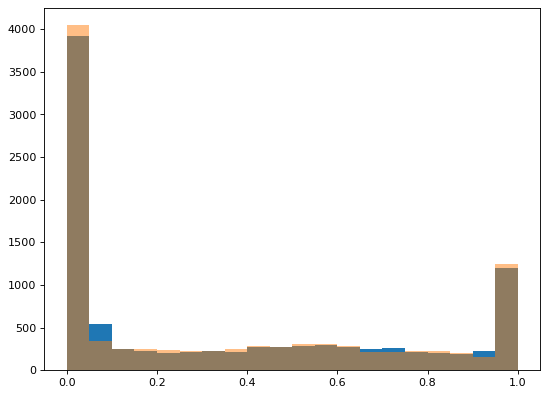

In [55]:
from matplotlib.pyplot import figure
#Comparaison des histogrammes:
figure(figsize=(8, 6), dpi=80)
plt.hist(np.transpose(original)[0], bins=20)  # arguments are passed to np.histogram
plt.hist(np.transpose(ds)[0], bins=20,alpha=0.5) 
plt.show()

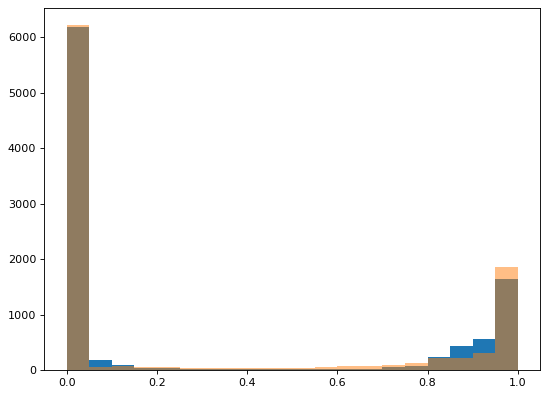

In [54]:
#Comparaison des histogrammes:
figure(figsize=(8, 6), dpi=80)
plt.hist(np.transpose(original)[1], bins=20)  # arguments are passed to np.histogram
plt.hist(np.transpose(ds)[1], bins=20,alpha=0.5) 
plt.show()

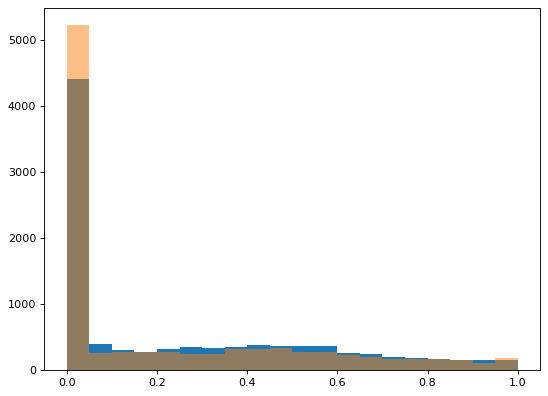

In [53]:
#Comparaison des histogrammes:
figure(figsize=(8, 6), dpi=80)
plt.hist(np.transpose(original)[2], bins=20)  # arguments are passed to np.histogram
plt.hist(np.transpose(ds)[2], bins=20,alpha=0.5) 
plt.show()

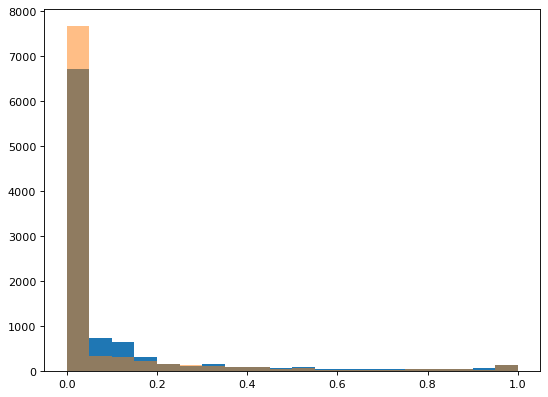

In [56]:
#Comparaison des histogrammes:
figure(figsize=(8, 6), dpi=80)
plt.hist(np.transpose(original)[3], bins=20)  # arguments are passed to np.histogram
plt.hist(np.transpose(ds)[3], bins=20,alpha=0.5) 
plt.show()